# This notebook aims to give a exploratory look at the project data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs

In [2]:
rsdt = xr.open_dataset("../data/CanESM5_hist_rsdt.nc")["rsdt"]
rsut = xr.open_dataset("../data/CanESM5_hist_rsut.nc")["rsut"]
rlut = xr.open_dataset("../data/CanESM5_hist_rlut.nc")["rlut"]

In [3]:
# Align datasets if needed
rsdt, rsut, rlut = xr.align(rsdt, rsut, rlut)

# Net TOA radiation (W/m²)
net_toa = rsdt - rsut - rlut

In [4]:
net_toa

<xarray.DataArray (member: 25, time: 1980, lat: 64, lon: 128)> Size: 2GB
array([[[[ -31.331879,  -31.513565,  -31.646866, ...,  -30.636734,
           -30.765137,  -30.879303],
         [ -30.062805,  -29.53357 ,  -30.109268, ...,  -31.501633,
           -30.504425,  -30.079727],
         [ -30.936813,  -30.485443,  -30.452087, ...,  -31.350174,
           -30.769135,  -31.306763],
         ...,
         [-170.18501 , -171.40823 , -172.62355 , ..., -167.22023 ,
          -168.32422 , -169.3624  ],
         [-163.81276 , -163.92891 , -164.20201 , ..., -162.845   ,
          -163.14824 , -163.19633 ],
         [-158.84091 , -158.88884 , -158.8951  , ..., -158.63293 ,
          -158.82306 , -158.87714 ]],

        [[ -70.805374,  -70.45918 ,  -70.309906, ...,  -71.56268 ,
           -71.24486 ,  -70.98067 ],
         [ -71.74466 ,  -70.8183  ,  -70.39676 , ...,  -75.01372 ,
           -73.68027 ,  -72.563095],
         [ -72.10239 ,  -71.56041 ,  -71.12138 , ...,  -75.15794 ,
           -73.59326 ,  -72.94533 ],
...
          -187.40912 , -188.37485 ],
         [-187.06013 , -187.7351  , -188.41855 , ..., -184.69745 ,
          -185.53973 , -186.37335 ],
         [-185.23962 , -185.43541 , -185.42734 , ..., -185.20369 ,
          -185.19452 , -185.19257 ]],

        [[ -20.286652,  -19.974365,  -20.029877, ...,  -20.59964 ,
           -20.563324,  -20.450287],
         [ -20.983536,  -20.575058,  -19.492783, ...,  -21.529022,
           -21.978088,  -21.577362],
         [ -18.939194,  -18.869965,  -19.261887, ...,  -19.89618 ,
           -19.96988 ,  -19.75978 ],
         ...,
         [-170.4384  , -170.24268 , -169.84267 , ..., -170.93105 ,
          -171.21391 , -171.03079 ],
         [-170.51921 , -170.92671 , -171.1461  , ..., -169.73068 ,
          -170.00574 , -170.14784 ],
         [-171.58076 , -171.76982 , -171.89813 , ..., -171.02684 ,
          -171.26776 , -171.37798 ]]]],
      shape=(25, 1980, 64, 128), dtype=float32)
Coordinates:
  * member   (member) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 512B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:          W m-2
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    standard_name:  toa_outgoing_longwave_flux
    long_name:      TOA Outgoing Longwave Radiation
    comment:        at the top of the atmosphere (to be compared with satelli...
    original_name:  OLR
    history:        2019-07-06T01:28:27Z altered by CMOR: Reordered dimension...

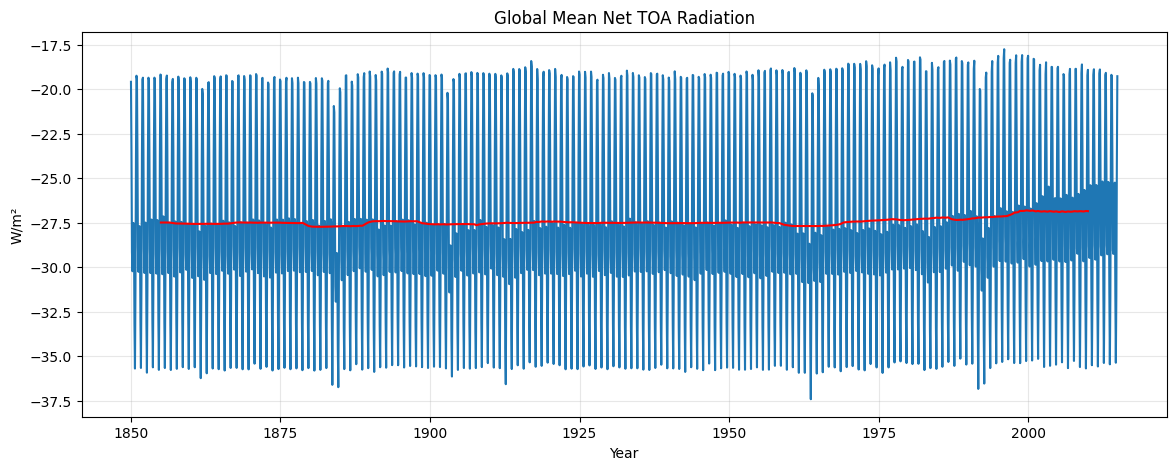

Trend = 0.00325 W m⁻² per year


In [8]:
# Spatial mean
global_mean = net_toa.mean(dim=["lat", "lon"])

# Ensemble mean
if "member" in global_mean.dims:
    global_mean = global_mean.mean(dim="member")

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,5))
years = global_mean["time"].dt.year + (global_mean["time"].dt.month-1)/12

coeffs = np.polyfit(years, global_mean.values, 1)
trend_line = np.polyval(coeffs, years)
window = 120  # months (aka 10 years)
global_mean_smooth = global_mean.rolling(time=window, center=True).mean()
ax.plot(years, global_mean)
ax.plot(years, global_mean_smooth, color="red", label=f"{window}-month rolling mean")
ax.set_title("Global Mean Net TOA Radiation")
ax.set_ylabel("W/m²")
ax.set_xlabel("Year")
ax.grid(alpha=0.3)
plt.show()
print(f"Trend = {coeffs[0]:.5f} W m⁻² per year")


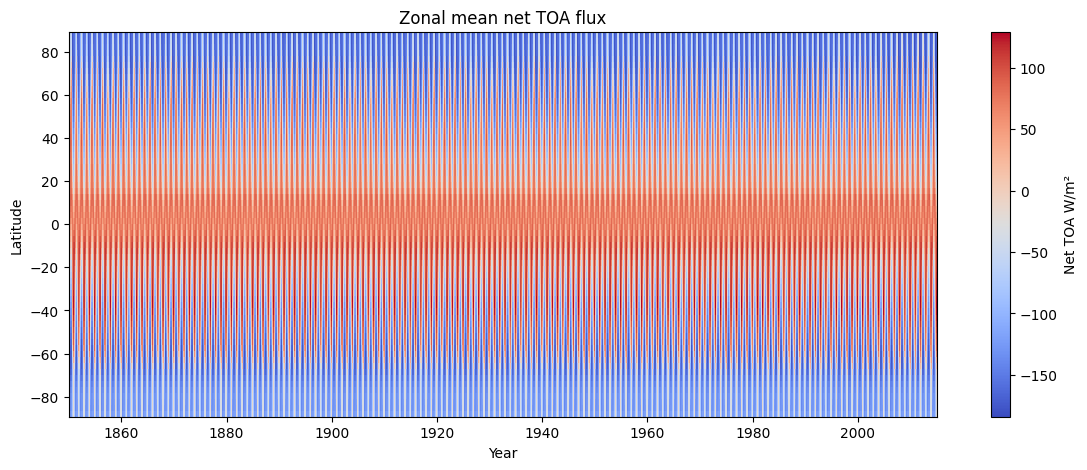

In [14]:
# Example: net_toa = rsdt - rsut - rlut
# net_toa = rsdt - rsut - rlut
# Here, assume net_toa is already computed

# Compute zonal mean (average over longitude)
zonal_mean = net_toa.mean(dim="lon")  # shape: (time, lat)

# Optional: ensemble mean
if "member" in zonal_mean.dims:
    zonal_mean = zonal_mean.mean(dim="member")  # now shape (time, lat)

# Convert time to numeric years
years = zonal_mean["time"].dt.year + (zonal_mean["time"].dt.month - 1)/12
lat = zonal_mean["lat"].values

# Plot as heatmap
plt.figure(figsize=(14,5))
plt.pcolormesh(years, lat, zonal_mean.T, cmap="coolwarm", shading="auto")
plt.colorbar(label="Net TOA W/m²")
plt.xlabel("Year")
plt.ylabel("Latitude")
plt.title("Zonal mean net TOA flux")
plt.show()


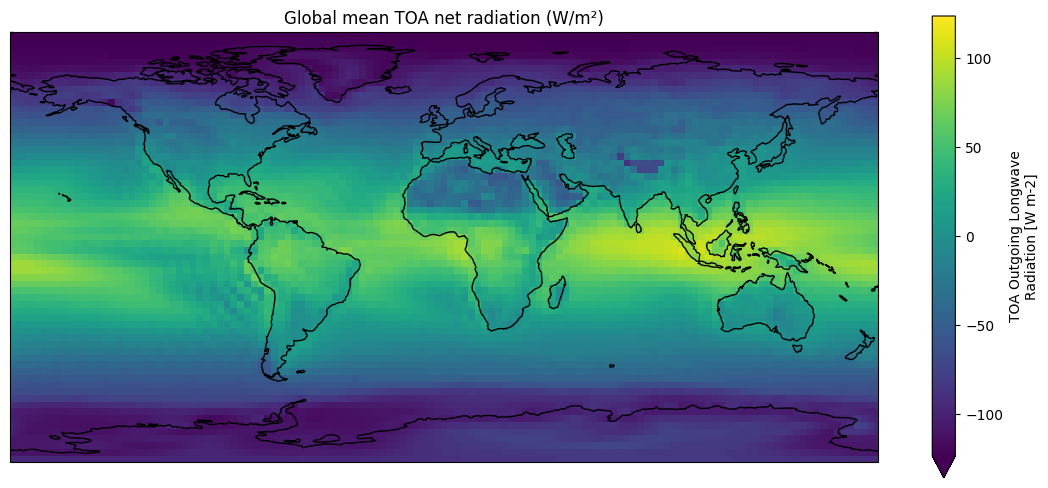

In [15]:
# Optional: mean over time (or choose a specific timestep)
net_toa_time_mean = net_toa
if "time" in net_toa_time_mean.dims:
    net_toa_time_mean = net_toa_time_mean.mean(dim="time")  # shape: (member, lat, lon)

# Optional: mean over ensemble members
if "member" in net_toa_time_mean.dims:
    net_toa_time_mean = net_toa_time_mean.mean(dim="member")  # shape: (lat, lon)

# Plot global map
fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
net_toa_time_mean.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    robust=True,
    x="lon",
    y="lat",
)
plt.title("Global mean TOA net radiation (W/m²)")
plt.show()

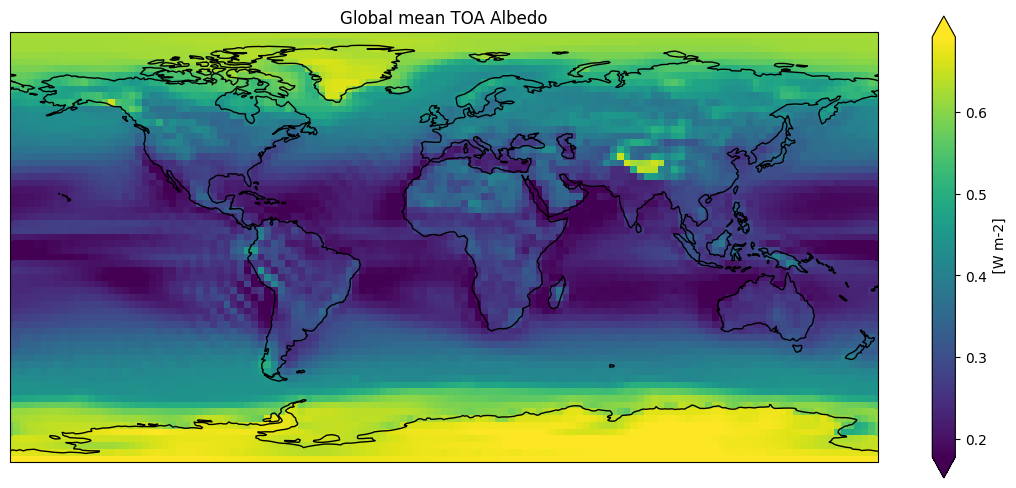

In [15]:
# Compute TOA albedo
albedo = rsut / rsdt  # element-wise division

# Optional: mean over time (or choose a specific timestep)
albedo_mean = albedo.mean(dim="time")  # shape: (member, lat, lon)

# Optional: mean over ensemble members
if "member" in albedo_mean.dims:
    albedo_mean = albedo_mean.mean(dim="member")  # shape: (lat, lon)

# Plot global map
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
albedo_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", robust=True, x="lon", y="lat")
plt.title("Global mean TOA Albedo")
plt.show()


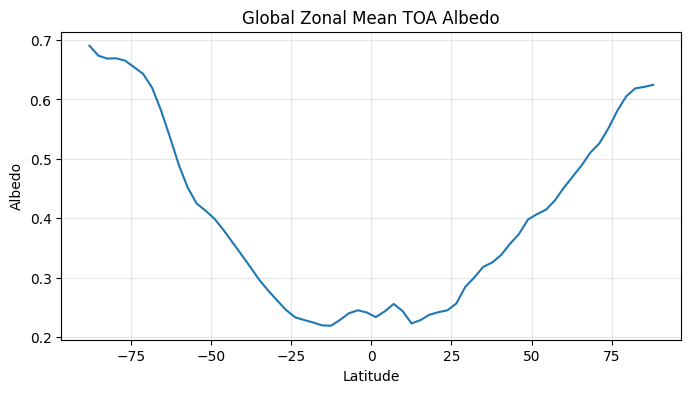

In [16]:
albedo_zonal = albedo_mean.mean(dim="lon")  # shape: (lat,)
plt.figure(figsize=(8,4))
plt.plot(albedo_zonal.lat, albedo_zonal)
plt.xlabel("Latitude")
plt.ylabel("Albedo")
plt.title("Global Zonal Mean TOA Albedo")
plt.grid(True, alpha=0.3)
plt.show()